In [13]:
import json
import string
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
with open('/content/Mental Health Conversational.json', 'r') as content:
  chatbot = json.load(content)
data = pd.DataFrame(chatbot['intents'])

In [16]:
dictionary = {"tag":[], "patterns":[], "responses":[]}
for i in range (len(data)):
  pattern = data[data.index==i]['patterns'].values[0]
  response = data[data.index==i]['responses'].values[0]
  tag = data[data.index==i]['tag'].values[0]
  for j in range (len(pattern)):
    dictionary['tag'].append(tag)
    dictionary['patterns'].append(pattern[j])
    dictionary['responses'].append(response)
data = pd.DataFrame.from_dict(dictionary)
data

,tag,patterns,responses
0,greeting,Hai,[Halo! Selamat bertemu denganmu. Bagaimana kab...
1,greeting,Halo,[Halo! Selamat bertemu denganmu. Bagaimana kab...
2,greeting,Hai apa kabar?,[Halo! Selamat bertemu denganmu. Bagaimana kab...
3,greeting,"Hai, yang di sana",[Halo! Selamat bertemu denganmu. Bagaimana kab...
4,greeting,Halo,[Halo! Selamat bertemu denganmu. Bagaimana kab...
...,...,...,...
225,fact_29,Bagaimana saya tahu kalau saya tidak sehat?,"[Jika keyakinan, pikiran, perasaan, atau peril..."
226,fact_30,Bagaimana saya bisa menjaga hubungan sosial? B...,"[Banyak orang yang sendirian saat ini, tapi ki..."
227,fact_31,Apa perbedaan antara kecemasan dan stres?,[Stres dan kecemasan sering digunakan secara b...
228,fact_32,Apa perbedaan antara kesedihan dan depresi?,[Kesedihan merupakan reaksi normal terhadap ke...


In [17]:
data['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about', 'skill', 'creation', 'help', 'sad', 'stressed',
       'worthless', 'depressed', 'happy', 'casual', 'anxious',
       'not-talking', 'sleep', 'scared', 'death', 'understand', 'done',
       'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat',
       'wrong', 'stupid', 'location', 'something-else', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user_meditation', 'hugu_useful', 'user-advice',
       'learn_mental_health', 'mental_health_fact', 'fact_1', 'fact_2',
       'fact_3', 'fact_4', 'fact_5', 'fact_6', 'fact_7', 'fact_8',
       'fact_9', 'fact_10', 'fact_11', 'fact_12', 'fact_13', 'fact_14',
       'fact_15', 'fact_16', 'fact_17', 'fact_18', 'fact_19', 'fact_20',
       'fact_21', 'fact_22', 'fact_23', 'fact_24', 'fact_25', 'fact_26',
       'fact_27', 'fact_28', 'fact_29', 'fact_30', 'fact_31', 'fact_32'],
      dtype=object)

In [18]:
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(data['patterns'])
tokenizer.get_config()

vocab = len(tokenizer.word_index)
print("Unique word : ",vocab)

pattern_train = tokenizer.texts_to_sequences(data['patterns'])
x_train = pad_sequences(pattern_train, padding="post")
print("Input shape : ", x_train.shape)

print()
label_encode = LabelEncoder()
y_train = label_encode.fit_transform(data['tag'])
print("Label shape : ", y_train.shape)
print("Output length : ", len(np.unique(y_train)))

Unique word :  287
Input shape :  (230, 18)

Label shape :  (230,)
Output length :  77


In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_length=x_train.shape[1], input_dim=vocab+1, output_dim = 100, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 18, 100)           28800     
                                                                 
 bidirectional_3 (Bidirecti  (None, 18, 128)           63744     
 onal)                                                           
                                                                 
 layer_normalization_5 (Lay  (None, 18, 128)           256       
 erNormalization)                                                
                                                                 
 bidirectional_4 (Bidirecti  (None, 18, 128)           74496     
 onal)                                                           
                                                                 
 layer_normalization_6 (Lay  (None, 18, 128)           256       
 erNormalization)                                     

In [20]:
history = model.fit(x_train, y_train,
                    batch_size=10, epochs=30,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)])

Epoch 1/30
23/23 [==============================] - 21s 116ms/step - loss: 4.6426 - accuracy: 0.0348
Epoch 2/30
23/23 [==============================] - 1s 59ms/step - loss: 3.4511 - accuracy: 0.2391
Epoch 3/30
23/23 [==============================] - 1s 29ms/step - loss: 2.5599 - accuracy: 0.4000
Epoch 4/30
23/23 [==============================] - 0s 18ms/step - loss: 1.8522 - accuracy: 0.6217
Epoch 5/30
23/23 [==============================] - 1s 27ms/step - loss: 1.3078 - accuracy: 0.7609
Epoch 6/30
23/23 [==============================] - 1s 28ms/step - loss: 0.9067 - accuracy: 0.8870
Epoch 7/30
23/23 [==============================] - 1s 26ms/step - loss: 0.6428 - accuracy: 0.9348
Epoch 8/30
23/23 [==============================] - 0s 20ms/step - loss: 0.4554 - accuracy: 0.9565
Epoch 9/30
23/23 [==============================] - 1s 30ms/step - loss: 0.3582 - accuracy: 0.9739
Epoch 10/30
23/23 [==============================] - 0s 19ms/step - loss: 0.2903 - accuracy: 0.9913
Epoch 1

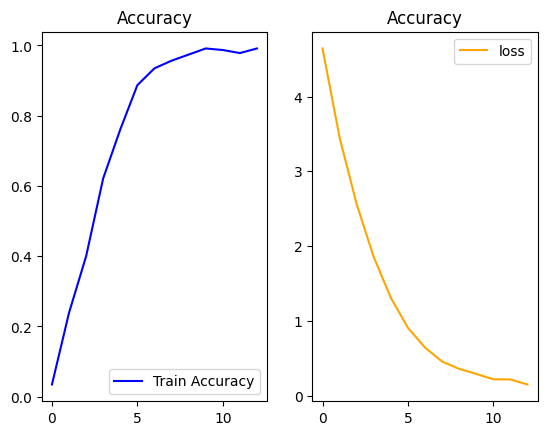

In [21]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color ='blue')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss', color='orange')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.show()

In [22]:
def chatbot_test():
  while True:
    user_input = input("User: ")
    pattern_test = tokenizer.texts_to_sequences([user_input])
    x_test = pad_sequences(pattern_test, padding="post")

    prediction = model.predict(x_test)[0]
    label = label_encode.inverse_transform([np.argmax(prediction)])[0]
    response = data[data['tag'] == label]['responses'].values[0]

    print("Chatbot: ", format(random.choice(response)))
    if label=='goodbye':
      break


In [28]:
schatbot_test()

User: Selamat siang
1/1 [==============================] - 0s 26ms/step
Chatbot:  Selamat siang. Bagaimana hari mu?
User: baik
1/1 [==============================] - 0s 26ms/step
Chatbot:  Senang mendengarnya. Saya senang kamu merasa seperti ini.
User: apakah saya boleh bertanya sesuatu
1/1 [==============================] - 0s 38ms/step
Chatbot:  Untuk diagnosis depresi, seseorang perlu mengalami suasana hati yang rendah atau kehilangan minat atau kesenangan dalam hidup setidaknya selama 2 minggu. Juga, mereka akan mengalami gejala-gejala berikut: perasaan sedih, putus asa, atau mudah tersinggung hampir setiap hari setiap hari.
User: Bolehkah saya bertanya sesuatu
1/1 [==============================] - 0s 27ms/step
Chatbot:  Tentu saja. Jangan ragu untuk menanyakan apa pun kepada saya. Saya akan melakukan yang terbaik untuk menjawab Anda
User: Ujianku sedang dekat
1/1 [==============================] - 0s 38ms/step
Chatbot:  Ada banyak jenis profesional kesehatan mental. Beragamnya pe

In [30]:
model.save("model_chatbot.h5")